In [44]:
# Updates March 15, 2025
# from google.colab import files
import pandas as pd

# uploaded = files.upload()

In [45]:
#  import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv("data/diabetes_prediction_dataset.csv")
# df = pd.read_csv("C:/Users/USSB697670/Desktop/GeorgiaTech/Data_Visual_Analytics/Project/diabetes_prediction_dataset.csv")
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Exploratory Data Analysis

In [47]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Checking missing value

In [49]:
print(df.isnull().sum())


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


Label Encoder

In [50]:
# encode the data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['smoking_history'] = le.fit_transform(df['smoking_history'])

In [51]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,0,27.32,6.2,90,0
99996,0,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,0,24.0,0,0,4,35.42,4.0,100,0


# Feature Importance

[0.00624913 0.12104193 0.02363809 0.01761589 0.02750607 0.13038074
 0.35383094 0.31973722]


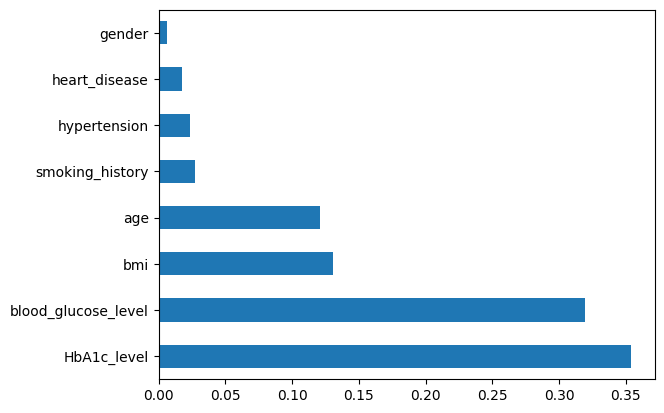

In [52]:
x = df.drop("diabetes",axis=1)
y = df["diabetes"]
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Splitting Data


In [53]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Model Selection

1. Logistic Regression

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [55]:


# Define features and target
X = df.drop(columns=["diabetes"])  # Ensure "diabetes" is the correct target column name
y = df["diabetes"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [56]:
# Make predictions
preds = model.predict(X_test)

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, preds))

Accuracy: 0.9559


Check class imbalance


In [57]:
from sklearn.metrics import classification_report

# Check class distribution
class_distribution = y.value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(class_distribution)

# Evaluate additional metrics

print("\nClassification Report:")
print(classification_report(y_test, preds))

Class Distribution (%):
diabetes
0    91.5
1     8.5
Name: proportion, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18300
           1       0.84      0.60      0.70      1700

    accuracy                           0.96     20000
   macro avg       0.90      0.79      0.84     20000
weighted avg       0.95      0.96      0.95     20000



Check class distribution

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


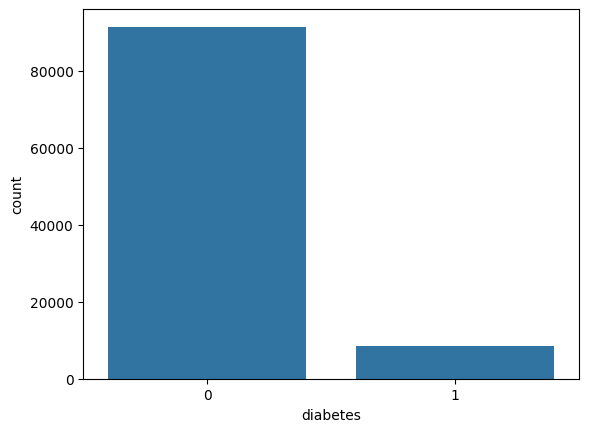

In [58]:
import seaborn as sns

sns.countplot(x=y)
print(y.value_counts(normalize=True))  # Shows class proportions


Handling class imbalance as the Model is predicting majority as 0 meaning "no diabetes"


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18300
           1       0.84      0.60      0.70      1700

    accuracy                           0.96     20000
   macro avg       0.90      0.79      0.84     20000
weighted avg       0.95      0.96      0.95     20000



Classification report confirms class imbalance issues.
Observations.
Precision for class "1" diabetes : 0.84 
PRecall for class "1" diabetes : 0.60 (low)
F1 score for 1 = 0.70 (Model is struggling to find diabetic cases)
Summary: Accuracy is high 0.97; but Recall is a problem.
The model is missing 40% of adctual diabetic cases.
